# Weisfeiler-Lehman Neural Machine for Link Prediction

## Importing the libraries

In [1]:
import networkx as nx
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import os
import random
import multiprocessing
from decimal import Decimal # It is used to avoid overflow error

## Importing the dataset

In [2]:
data_folder_path = os.path.join(os.getcwd(),'data')
data_path = os.path.join(data_folder_path, 'DG-Miner_miner-disease-gene.tsv')

data = pd.read_csv(data_path, sep='\t', header=0, names=['diseases','genes'])

In [3]:
data

,diseases,genes
0,MESH:D005756,A0A087WZV0
1,MESH:D055370,P11464
2,MESH:D007410,Q92945
3,MESH:D014062,Q6ISS4
4,MESH:D054549,Q96RU8
...,...,...
15509614,MESH:D006086,E9PDE8
15509615,MESH:D002869,O95994
15509616,MESH:D009182,E9PFI4
15509617,MESH:D015433,A0A087WWV9


In [4]:
data.sort_values(by=['diseases'])

,diseases,genes
10673635,# Disease(MESH),Gene
14511576,MESH:C000600608,Q8NCH0
7823287,MESH:C531609,P47712
4140998,MESH:C531609,P01270
6158148,MESH:C531609,P13716
...,...,...
11880360,OMIM:613789,P07358
3998525,OMIM:613790,P07357
10928321,OMIM:613843,O00294
6683297,OMIM:614456,O75030


## Removing of the "fake" row in the Pandas dataframe obtained from the dataset file

In [3]:
data = data.drop(10673635)
data.reset_index(drop=True, inplace=True)

In [4]:
diseases = np.sort(data.diseases.unique())
genes = np.sort(data.genes.unique())
print(diseases)
print(genes)

['MESH:C000600608' 'MESH:C531609' 'MESH:C531616' ... 'OMIM:613843'
 'OMIM:614456' 'OMIM:614869']
['A0A024QZ42' 'A0A024QZX5' 'A0A024R0T9' ... 'U3KPV4' 'W5XKT8' 'X6R868']


## Sample nodes, in order to be able to compute the enclosing subgraphs in a reasonable time

In [5]:
random.seed(45)
DROP_NODE_PROB = 0.8

def sample_data(p, genes, diseases):
    sampled_diseases = []
    for disease in diseases:
        i = random.random()
        if i>p:
            sampled_diseases.append(disease)
    sampled_genes = []
    for gene in genes:
        i = random.random()
        if i>p:
            sampled_genes.append(gene)
    return sampled_genes, sampled_diseases

genes, diseases = sample_data(DROP_NODE_PROB, genes, diseases)
num_genes = len(genes)
num_diseases = len(diseases)
num_nodes = num_diseases + num_genes
print("After sampling we have left {} genes and {} diseases".format(num_genes, num_diseases))

After sampling we have left 3528 genes and 1141 diseases


In [6]:
data = data[(data.diseases.isin(diseases)) & (data.genes.isin(genes))]
data

,diseases,genes
12,MESH:D006975,P22033
29,MESH:D003922,Q9UL25
39,MESH:D006505,Q8WY91
55,MESH:D013290,Q16576
67,MESH:D014591,P22760
...,...,...
15509511,MESH:D001281,Q9UD71
15509548,MESH:D008133,O95239
15509566,MESH:D015769,P30086
15509598,MESH:D007021,Q6UW56


In [7]:
data.diseases.nunique(), data.genes.nunique()

(729, 3524)

## Some sampled nodes (diseases or genes) are not present in the filtered dataframe, we add it

In [8]:
data_genes = data.genes.unique()
genes_to_add = []
for gene in genes:
    if gene not in data_genes:
        genes_to_add.append(gene)
data_diseases = data.diseases.unique()
diseases_to_add = []
for disease in diseases:
    if disease not in data_diseases:
        diseases_to_add.append(disease)
data_genes = None
data_diseases = None
genes_to_add = np.array(genes_to_add)
diseases_to_add = np.array(diseases_to_add)

In [9]:
diseases = np.concatenate( (data['diseases'].unique(), diseases_to_add) )
genes = np.concatenate( (data['genes'].unique(), genes_to_add) )
num_diseases = len(diseases)
num_genes = len(genes)
nodes_list = np.concatenate( (genes, diseases) ) # It represents the order in which we will consider the rows (columns) of the adj matrix of the network
diseases = None
genes = None
num_diseases, num_genes

(1141, 3528)

In [10]:
genes_to_add, diseases_to_add, nodes_list

(array(['Q5J5C9', 'Q6ZVW7', 'Q9H339', 'Q9NYZ4'], dtype='<U6'),
 array(['MESH:C535314', 'MESH:C535328', 'MESH:C535344', 'MESH:C535382',
        'MESH:C535395', 'MESH:C535396', 'MESH:C535418', 'MESH:C535424',
        'MESH:C535460', 'MESH:C535478', 'MESH:C535501', 'MESH:C535502',
        'MESH:C535540', 'MESH:C535566', 'MESH:C535576', 'MESH:C535600',
        'MESH:C535627', 'MESH:C535661', 'MESH:C535684', 'MESH:C535702',
        'MESH:C535705', 'MESH:C535729', 'MESH:C535737', 'MESH:C535741',
        'MESH:C535780', 'MESH:C535788', 'MESH:C535852', 'MESH:C535896',
        'MESH:C535898', 'MESH:C535904', 'MESH:C535924', 'MESH:C535934',
        'MESH:C535959', 'MESH:C535982', 'MESH:C536008', 'MESH:C536029',
        'MESH:C536030', 'MESH:C536044', 'MESH:C536045', 'MESH:C536049',
        'MESH:C536079', 'MESH:C536080', 'MESH:C536088', 'MESH:C536089',
        'MESH:C536092', 'MESH:C536129', 'MESH:C536163', 'MESH:C536167',
        'MESH:C536185', 'MESH:C536192', 'MESH:C536196', 'MESH:C536200',
 

In [11]:
type(nodes_list[0]), type(diseases_to_add[0]), type(genes_to_add[0])

(str, numpy.str_, numpy.str_)

## Create a graph from the Pandas dataframe

In [12]:
network_train = nx.convert_matrix.from_pandas_edgelist(data, 'diseases', 'genes')
data = None
network_train.add_nodes_from(diseases_to_add)
network_train.add_nodes_from(genes_to_add)
diseases_to_add = None
genes_to_add = None

In [13]:
total_n_nodes, total_n_edges = network_train.number_of_nodes(), network_train.number_of_edges()
total_n_nodes, total_n_edges

(4669, 619437)

## Creating the test network

In [14]:
network_test = nx.Graph()
network_test.add_nodes_from(network_train.nodes)

In [15]:
train_ratio = 0.01
n_links = network_train.number_of_edges()
n_links_train = math.ceil(train_ratio * n_links)
n_links_test = n_links_train

In [16]:
n_links, n_links_train, n_links_test

(619437, 6195, 6195)

In [17]:
selected_pos_links_id = np.random.choice(np.arange(n_links), size=n_links_train + n_links_test, replace=False)

In [18]:
links = list(network_train.edges)

In [19]:
train_links = []
for i in range(n_links_train):
    train_links.append(links[selected_pos_links_id[i]])

test_links = []
for i in range(n_links_train, n_links_train + n_links_test):
    test_links.append(links[selected_pos_links_id[i]])

selected_pos_links_id = None
links = None
total_adj_triu = scipy.sparse.triu(nx.adj_matrix(network_train, nodes_list), k=1).tocsr()
network_train.remove_edges_from(test_links)
network_test.add_edges_from(test_links)

In [20]:
network_train.number_of_edges(), network_test.number_of_edges(), len(train_links)

(613242, 6195, 6195)

In [21]:
network_train.number_of_nodes(), network_test.number_of_nodes()

(4669, 4669)

## Sampling negative links

In [22]:
n_links_train_pos = len(train_links)
n_links_test_pos = network_test.number_of_edges()
n_links_train_neg = n_links_train_pos
n_links_test_neg = n_links_test_pos
n_links_train_pos, n_links_test_pos, n_links_train_neg, n_links_test_neg

(6195, 6195, 6195, 6195)

In [23]:
neg_network_train = nx.Graph()
neg_network_train.add_nodes_from(network_train.nodes)
neg_network_test = nx.Graph()
neg_network_test.add_nodes_from(network_train.nodes)

In [24]:
list(network_train.edges)[:10] # All the links in our network are tuples of the form: (disease, gene)

[('MESH:D006975', 'P22033'),
 ('MESH:D006975', 'O75914'),
 ('MESH:D006975', 'O60356'),
 ('MESH:D006975', 'Q7Z401'),
 ('MESH:D006975', 'Q9NYG5'),
 ('MESH:D006975', 'B7Z5N5'),
 ('MESH:D006975', 'P84090'),
 ('MESH:D006975', 'P43251'),
 ('MESH:D006975', 'A8MV65'),
 ('MESH:D006975', 'Q9UM47')]

In [25]:
def get_neg_links(adj_triu, num_neg_edges, nodes_list, num_genes, num_diseases):

    neg_edges = set()
    while len(neg_edges) < num_neg_edges:

        i, j = random.randint(0, num_genes-1), random.randint(num_genes, num_genes + num_diseases - 1)
        if adj_triu[i, j] == 0:
            neg_edges.add( (nodes_list[j], nodes_list[i]) )

    return list(neg_edges)

In [26]:
neg_links = get_neg_links(total_adj_triu, n_links_train_neg + n_links_test_neg, nodes_list, num_genes, num_diseases)
total_adj_triu = None
nodes_list = None
selected_links = []
for i in range(n_links_train_neg):
    selected_links.append(neg_links[i])
neg_network_train.add_edges_from(selected_links)

selected_links = []
for i in range(n_links_train_neg, n_links_train_neg + n_links_test_neg):
    selected_links.append(neg_links[i])
neg_links = None
neg_network_test.add_edges_from(selected_links)
selected_links = None

In [27]:
neg_network_train.number_of_nodes(), neg_network_test.number_of_nodes()

(4669, 4669)

In [28]:
neg_network_train.number_of_edges(), neg_network_test.number_of_edges()

(6195, 6195)

## Grouping training and test links

In [29]:
all_links_train = train_links + list(neg_network_train.edges)
label_train = [1] * len(train_links) + [0] * len(neg_network_train.edges)
neg_network_train = None
len(all_links_train), len(label_train)

(12390, 12390)

In [30]:
all_links_test = list(network_test.edges) + list(neg_network_test.edges)
label_test = [1] * len(network_test.edges) + [0] * len(neg_network_test.edges)
network_test = None
neg_network_test = None
len(all_links_test), len(label_test)

(12390, 12390)

In [31]:
y_train, y_test = np.array(label_train), np.array(label_test)
label_train = None
label_test = None

## Extracting enclosing subgraph for each links

In [32]:
link = all_links_train[12]
link

('MESH:D033461', 'Q12996')

In [33]:
fringe = [link]
subgraph = nx.Graph()

In [34]:
def enclosing_subgraph(fringe, network, subgraph, distance):
    neighbor_links = []
    for link in fringe:
        u = link[0]
        v = link[1]
        neighbor_links = neighbor_links + list(network.edges(u))
        neighbor_links = neighbor_links + list(network.edges(v))
    tmp_subgraph = subgraph.copy()
    tmp_subgraph.add_edges_from(neighbor_links)
    # Remove duplicate and existed edge
    neighbor_links = [li for li in tmp_subgraph.edges() if li not in subgraph.edges()]
    tmp_subgraph = subgraph.copy()
    tmp_subgraph.add_edges_from(neighbor_links, distance=distance, inverse_distance=1/distance)
    return neighbor_links, tmp_subgraph

In [35]:
fringe, subgraph = enclosing_subgraph(fringe, network_train, subgraph, distance=1)
#nx.draw(subgraph, with_labels=True)
subgraph.number_of_nodes(), subgraph.number_of_edges()

(2280, 2279)

In [36]:
def extract_enclosing_subgraph(link, network, size=10):
    fringe = [link]
    subgraph = nx.Graph()
    distance = 0
    subgraph.add_edge(link[0], link[1], distance=distance)
    while subgraph.number_of_nodes() < size and len(fringe) > 0:
        distance += 1
        fringe, subgraph = enclosing_subgraph(fringe, network, subgraph, distance)
    
    #print("End while")
    tmp_subgraph = network.subgraph(subgraph.nodes)
    #print("Net subgraph obtained")
    additional_edges = [li for li in tmp_subgraph.edges if li not in subgraph.edges]
    #print("Additional edges obtained")
    subgraph.add_edges_from(additional_edges, distance=distance+1, inverse_distance=1/(distance+1))
    #print("Subgraph completed")
    return subgraph

In [37]:
e_subgraph = extract_enclosing_subgraph(link, network_train)
#nx.draw(e_subgraph, with_labels=True)

In [38]:
e_subgraph.number_of_nodes(), e_subgraph.number_of_edges()

(2280, 331817)

In [39]:
%%timeit
extract_enclosing_subgraph(link, network_train)

2.69 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Subgraph encoding
### Palette-WL for vertex ordering

In [40]:
def compute_geometric_mean_distance(subgraph, link):
    u = link[0]
    v = link[1]
    subgraph.remove_edge(u, v)
    
    n_nodes = subgraph.number_of_nodes()
    u_reachable = nx.descendants(subgraph, source=u)
    v_reachable = nx.descendants(subgraph, source=v)
    #print(u_reachable, v_reachable)
    for node in subgraph.nodes:
        distance_to_u = 0
        distance_to_v = 0
        if node != u:
            distance_to_u = nx.shortest_path_length(subgraph, source=node, target=u) if node in u_reachable else Decimal(2 ** n_nodes)

        if node != v:
            distance_to_v = nx.shortest_path_length(subgraph, source=node, target=v) if node in v_reachable else Decimal(2 ** n_nodes)
        subgraph.nodes[node]['avg_dist'] = math.sqrt(distance_to_u * distance_to_v)
    
    subgraph.add_edge(u, v, distance=0)
    
    return subgraph

In [41]:
e_subgraph = compute_geometric_mean_distance(e_subgraph, link)

In [42]:
avg_dist = nx.get_node_attributes(e_subgraph, 'avg_dist')
avg_dist

96HU1': 1.4142135623730951,
 'Q96LI5': 1.4142135623730951,
 'O60563': 1.4142135623730951,
 'Q15003': 1.4142135623730951,
 'P52737': 1.4142135623730951,
 'P41273': 1.4142135623730951,
 'Q8IZU8': 1.4142135623730951,
 'Q15021': 1.4142135623730951,
 'Q9C009': 1.4142135623730951,
 'A8MQ02': 1.4142135623730951,
 'Q8NB50': 1.4142135623730951,
 'O15370': 1.4142135623730951,
 'Q96AY2': 1.4142135623730951,
 'A8MVV6': 1.4142135623730951,
 'Q92793': 1.4142135623730951,
 'Q15056': 1.4142135623730951,
 'O15198': 1.4142135623730951,
 'Q9BSK4': 1.4142135623730951,
 'P47944': 1.4142135623730951,
 'Q9UBP4': 1.4142135623730951,
 'Q92466': 1.4142135623730951,
 'P43320': 1.4142135623730951,
 'P13671': 1.4142135623730951,
 'E9PG37': 1.4142135623730951,
 'P57740': 1.4142135623730951,
 'Q96AB3': 1.4142135623730951,
 'O14818': 1.4142135623730951,
 'Q13319': 1.4142135623730951,
 'Q9UIL8': 1.4142135623730951,
 'P13489': 1.4142135623730951,
 'A0A0G2JNH5': 1.4142135623730951,
 'F8W876': 1.4142135623730951,
 'Q9NZ4

In [43]:
set(avg_dist.values()) # The dataset is extremely connected

{0.0, 1.4142135623730951}

In [44]:
def prime(x):
    if x < 2:
        return False
    if x == 2 or x == 3:
        return True
    for i in range(2, x):
        if x % i == 0:
            return False
    return True

In [45]:
prime_numbers = np.array([i for i in range(100000) if prime(i)], dtype=np.int)

In [46]:
prime_numbers.shape

(9592,)

In [47]:
def palette_wl(subgraph, link):
    tmp_subgraph = subgraph.copy()
    if tmp_subgraph.has_edge(link[0], link[1]):
        tmp_subgraph.remove_edge(link[0], link[1])
    avg_dist = nx.get_node_attributes(tmp_subgraph, 'avg_dist')
    
    df = pd.DataFrame.from_dict(avg_dist, orient='index', columns=['hash_value'])
    df = df.sort_index()
    df['order'] = df['hash_value'].rank(axis=0, method='min').astype(np.int)
    df['previous_order'] = np.zeros(df.shape[0], dtype=np.int)
    adj_matrix = nx.adj_matrix(tmp_subgraph, nodelist=sorted(tmp_subgraph.nodes)).todense()
    while any(df.order != df.previous_order):
        df['log_prime'] = np.log(prime_numbers[df['order'].values])
        total_log_primes = np.ceil(np.sum(df.log_prime.values))
        df['hash_value'] = adj_matrix * df.log_prime.values.reshape(-1, 1) / total_log_primes + df.order.values.reshape(-1, 1)
        df.previous_order = df.order
        df.order = df.hash_value.rank(axis=0, method='min').astype(np.int)
    nodelist = df.order.sort_values().index.values
    return nodelist

In [48]:
nodelist = palette_wl(e_subgraph, link)
nodelist

array(['Q12996', 'MESH:D033461', 'Q6L8G5', ..., 'MESH:D004487',
       'MESH:D013927', 'MESH:D009202'], dtype=object)

In [49]:
size = 10
if len(nodelist) > size:
    nodelist = nodelist[:size]
    e_subgraph = e_subgraph.subgraph(nodelist)
    nodelist = palette_wl(e_subgraph, link)

In [50]:
nx.adj_matrix(e_subgraph, nodelist).todense()

matrix([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [51]:
nodelist

array(['Q12996', 'MESH:D033461', 'E2JJS1', 'Q587J8', 'Q6L8G5', 'Q6UXX5',
       'Q6ZN06', 'Q8NHC8', 'Q8WUE5', 'Q96KT7'], dtype=object)

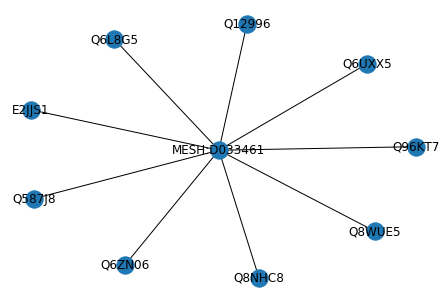

In [52]:
nx.draw(e_subgraph, with_labels=True)

### Represent enclosing subgraphs as adjacency matrices

In [53]:
def sample(subgraph, nodelist, weight='weight', size=10):
    adj_matrix = nx.adj_matrix(subgraph, weight=weight, nodelist=nodelist).todense()
    vector = np.asarray(adj_matrix)[np.triu_indices(len(adj_matrix), k=1)]
    d = size * (size - 1) // 2
    if len(vector) < d:
        vector = np.append(vector, np.zeros(d - len(vector)))
    return vector[1:]

In [54]:
sample(e_subgraph, nodelist, size=10)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

### Subgraph encoding test

In [55]:
link

('MESH:D033461', 'Q12996')

In [56]:
e_subgraph = extract_enclosing_subgraph(link, network_train, size=10)
e_subgraph = compute_geometric_mean_distance(e_subgraph, link)
nodelist = palette_wl(e_subgraph, link)
if len(nodelist) > size:
    nodelist = nodelist[:size]
    e_subgraph = e_subgraph.subgraph(nodelist)
    nodelist = palette_wl(e_subgraph, link)
embeded = sample(e_subgraph, nodelist, size=10)

In [57]:
embeded

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

## Enclosing subgraph encoding for each links

In [58]:
def encode_link(link, network, weight='weight', size=10):
    e_subgraph = extract_enclosing_subgraph(link, network, size=size)
    e_subgraph = compute_geometric_mean_distance(e_subgraph, link)
    nodelist = palette_wl(e_subgraph, link)
    if len(nodelist) > size:
        nodelist = nodelist[:size]
        e_subgraph = e_subgraph.subgraph(nodelist)
        nodelist = palette_wl(e_subgraph, link)
    embeded_link = sample(e_subgraph, nodelist, weight=weight, size=size)
    return embeded_link

In [63]:
%%timeit
encode_link(link, network_train, weight='inverse_distance', size=10)

32.2 s ± 290 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
from functools import partial

In [65]:
pool = multiprocessing.Pool()
X_train = np.array(list(pool.map(partial(encode_link, network=network_train, weight='weight', size=10), all_links_train)))

In [66]:
X_train.shape

(12390, 44)

In [67]:
X_test = np.array(list(pool.map(partial(encode_link, network=network_train, weight='weight', size=10), all_links_test)))

In [85]:
X_test.shape

(12390, 44)

In [84]:
def convert_into_tuple(x):
    return tuple(x)

dist_elems_train = [convert_into_tuple(xi) for xi in X_train]
dist_elems_test = [convert_into_tuple(xi) for xi in X_test]
len(set(dist_elems_train)), len(set(dist_elems_test)) # We have only 48 different embs in the training set (same thing for the test set) among 12 390 links

(48, 48)

In [86]:
from numpy import save

save('X_train.npy', X_train)
save('X_test.npy', X_test)

In [90]:
from sklearn.utils import shuffle
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [91]:
X_train_shuffle.shape, y_train.shape

((12390, 44), (12390,))

## Neural Network Learning

In [114]:
from sklearn.neural_network import MLPClassifier

In [115]:
model = MLPClassifier(hidden_layer_sizes=(32, 32, 16),
                      alpha=1e-3,
                      batch_size=128,
                      learning_rate_init=0.001,
                      max_iter=10,
                      verbose=0,
                      early_stopping=False,
                      tol=-10000)

In [116]:
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 100
N_BATCH = 128
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        model.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(model.score(X_train, y_train))

    # SCORE TEST
    scores_test.append(model.score(X_test, y_test))

    epoch += 1

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

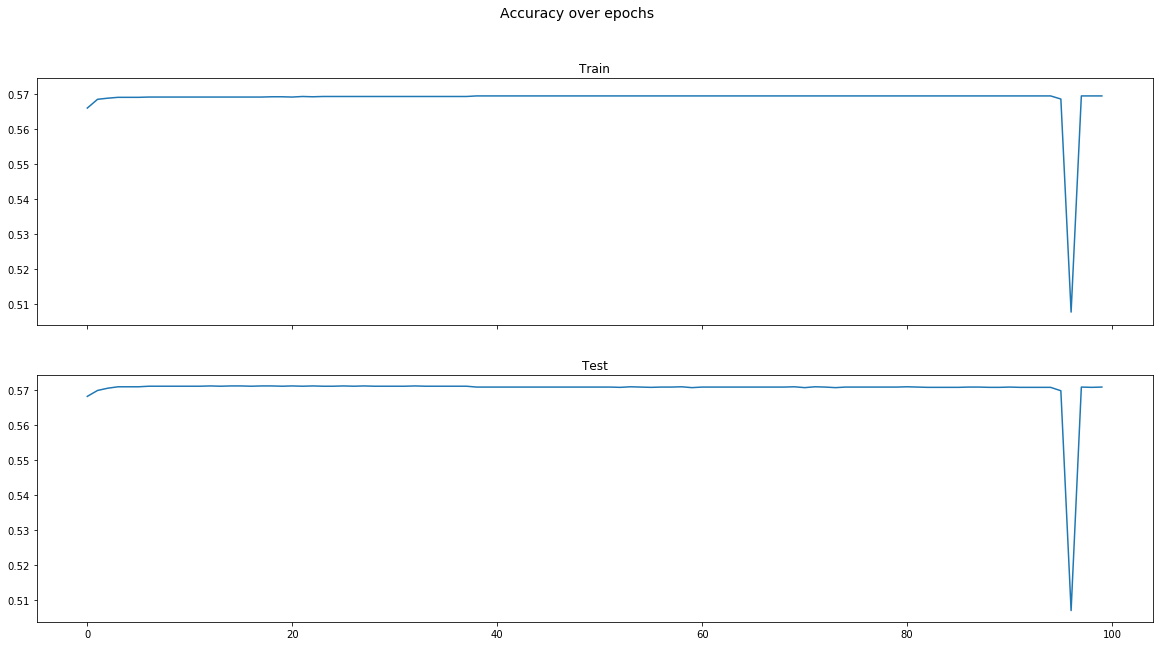

In [121]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax[0].plot(scores_train)
ax[0].set_title('Train')
ax[1].plot(scores_test)
ax[1].set_title('Test')
fig.suptitle("Accuracy over epochs", fontsize=14)
plt.show()

In [118]:
predictions = model.predict(X_test)

In [119]:
from sklearn import metrics

In [120]:
metrics.accuracy_score(y_test, predictions)

0.5709443099273608